# Aprendizado de máquina - TP 2
## Pedro Tavares de Carvalho
Para o segundo trabalho prático da disciplina de aprendizado de máquina, foi pedida a implementação e análise de uma rede neural convolucional e de um processo de transferência de aprendizado.  

Essa análise será feita utilizando `tensorflow` e `keras`, além de `pandas` e `numpy` para a formatação e visualização dos dados.

O primeiro o passo para a realização do trabalho será importar as bibliotecas necessárias. O `tensorflow` é uma biblioteca de representação numérica que toma proveito da aceleração de computação de placas de vídeo, além de possuir representações de gradiente e backward propagation implementadas na biblioteca em si. Isso a torna extremamente conveniente para a representação de redes neurais.

A biblioteca `keras` é uma biblioteca que fornece modelos de redes neurais e de otimizadores que usam o `tensorflow` para a montagem da rede e de seus parâmetros.

In [0]:
import tensorflow as tf # Tensorflow para representação dos dados em tensores
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Dados e camadas de redes neurais do keras
from tensorflow import keras

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Bibliotecas de manipulação de dados
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Depois de importar a biblioteca, baixamos os dados que serão usados para o treinamento da rede neural. No caso desse trabalho, o banco de dados usado será o `CIFAR10`, que são imagens de 10 classes diferentes e cujo banco de dados está disponível para download pelo `keras`, facilitando a aquisição dos dados.


In [0]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

Definindo os nomes das classes que serão classificadas pelo modelo e o formato das imagens.

In [3]:
classes = ('Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

imgFormat = train_x.shape[1:]
print(imgFormat)

(32, 32, 3)


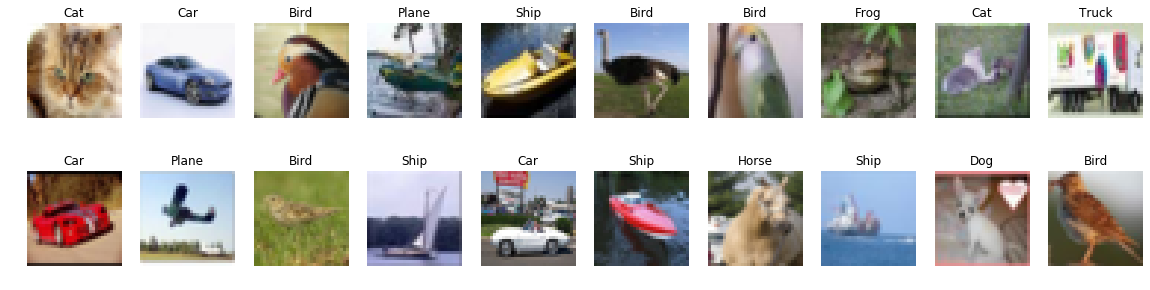

In [4]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, train_x.shape[0])
        axes[i][j].imshow(train_x[img_i], cmap="gray")
        axes[i][j].set_title("{}".format(classes[int(train_y[img_i])]))
        axes[i][j].axis("off")
plt.show()

O primeiro passo é normalizar as entradas e separar a saída em classes diferentes para permitir a classificação por redes neurais.

In [0]:
train_y = train_y/255
test_y = test_y/255
train_y = pd.get_dummies(train_y[:, 0]).values
test_y = pd.get_dummies(test_y[:, 0]).values

Como faremos o *transfer learning*, os dados serão separados em dois grupos, e, como determinado pela especificação, um dos grupos será com as classes 4 e 9, e o outro com as outras classes, visto que o meu número de matrícula é 2017014499.

In [0]:
train_x_b = np.array([train_x[i] for i in range(len(train_y)) if train_y[i][4] == 1 or train_y[i][9] == 1])
train_x_a = np.array([train_x[i] for i in range(len(train_y)) if not(train_y[i][4] == 1 or train_y[i][9] == 1)])
train_y_b = np.array([train_y[i] for i in range(len(train_y)) if train_y[i][4] == 1 or train_y[i][9] == 1])
train_y_a = np.array([train_y[i] for i in range(len(train_y)) if not(train_y[i][4] == 1 or train_y[i][9] == 1)])

test_x_b = np.array([test_x[i] for i in range(len(test_y)) if test_y[i][4] == 1 or test_y[i][9] == 1])
test_x_a = np.array([test_x[i] for i in range(len(test_y)) if not(test_y[i][4] == 1 or test_y[i][9] == 1)])
test_y_b = np.array([test_y[i] for i in range(len(test_y)) if test_y[i][4] == 1 or test_y[i][9] == 1])
test_y_a = np.array([test_y[i] for i in range(len(test_y)) if not(test_y[i][4] == 1 or test_y[i][9] == 1)])

Depois de separados os dados e as classes transformadas em arrays de classes, normalizamos as entradas da rede neural.

In [7]:
print(train_y_b.shape, train_y_a.shape)

(10000, 10) (40000, 10)


## A rede neural
A rede neural especificada possui quatro camadas de convolução 2D e duas camadas de *Max Pool*. A ordem dessas camadas foi deixada para determinação do aluno. 

Por experimentação, a ordem decidida foi:


`Input -> Conv1 -> Conv2 -> Pool1 -> Conv3 -> Conv4 -> Pool2 -> Flatten -> Dense1 -> Dropout -> Dense2 -> Output`

O número de filtros de convolução foi de 32 na camada `Conv1`, duplicando o número de filtros a cada camada de convolução. Também por experimentação, o dropout condizente à camada é por volta de 0.85.

![imagem_NN](https://raw.githubusercontent.com/ptcar2009/TP_ML_2/master/.images/diagram.png)

In [0]:
convSize = 32 # número de filtros de convolução na primeira camada
drop = 0.8 # Rate de dropout

In [0]:
def startModel():
    # Camada de entrada do modelo
    model_input = keras.layers.Input(
        shape=imgFormat, 
        name='Input')

    # Primeira camada de convolução, com 'convSize' filtros
    x = keras.layers.Conv2D(
        convSize, 
        kernel_size=(3,3), 
        activation='relu', 
        padding='same', 
        name='Conv1')(model_input)

    # Segunda camada de convolução, com 2*convSize filtros
    x = keras.layers.Conv2D(
        convSize*2, 
        kernel_size=(3,3), 
        activation='relu', 
        padding='same', 
        name='Conv2')(x)

    # Primeira camada de Max Pooling
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        name="Pool1")(x)

    # Terceira camada de convolução, com 4*convSize filtros
    x = keras.layers.Conv2D(
        convSize*4,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        name='Conv3')(x)

    # Quarta camada de convolução, com 8*convSize filtros
    x = keras.layers.Conv2D(
        convSize*8, 
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        name='Conv4')(x)

    # Segunda camada de Max Pooling
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2), 
        name="Pool2")(x)

    # Camada de "linearização" dos parâmetros para um vetor unidimensional
    x = keras.layers.Flatten(
        name="Flatten")(x)

    # Camada fully connected
    x = keras.layers.Dense(
        256, 
        activation="relu", 
        name="Dense1")(x)

    # Camada de regularização, com probabilidade de dropout 'drop'
    x = keras.layers.Dropout(
        drop, 
        name="Dropout")(x)

    # Camada final de classificação
    model_output = keras.layers.Dense(
        len(classes), 
        activation='softmax', 
        name="Output")(x)

    # junção do modelo completo
    return keras.models.Model(model_input, model_output)


## O treinamento para os rótulos do grupo `A`
Com esse formato de modelo, o próximo passo é a compilação e o treinamento do mesmo. O *learning rate* que melhor funcionou para esse modelo foi entre $0.001$ e $0.0005$. Decidi usar $0.001$ pois a convergência do modelo é mais rápida, e como o otimizador *Adam* adapta o *learning rate* a medida da época do treinamento, isso evita a divergência em estados mais avançados do gradiente.

In [31]:
modelA = startModel()

optimizer = keras.optimizers.Adam(
    lr=0.001)

modelA.compile(
    optimizer,
    loss="categorical_crossentropy", 
    metrics=["accuracy"])

historyA = modelA.fit(
    train_x_a,
    train_y_a,
    batch_size=32,
    epochs=20,
    validation_data=(
        test_x_a, 
        test_y_a)
    )

Train on 40000 samples, validate on 8000 samples
Epoch 1/20
40000/40000 [==============================] - 26s 640us/sample - loss: 1.9266 - acc: 0.3667 - val_loss: 1.2944 - val_acc: 0.5337
Epoch 2/20
40000/40000 [==============================] - 25s 628us/sample - loss: 1.3053 - acc: 0.5168 - val_loss: 1.0103 - val_acc: 0.6284
Epoch 3/20
40000/40000 [==============================] - 25s 625us/sample - loss: 1.1557 - acc: 0.5733 - val_loss: 0.9468 - val_acc: 0.6500
Epoch 4/20
40000/40000 [==============================] - 25s 625us/sample - loss: 1.0714 - acc: 0.6099 - val_loss: 0.9602 - val_acc: 0.6529
Epoch 5/20
40000/40000 [==============================] - 25s 624us/sample - loss: 1.0182 - acc: 0.6326 - val_loss: 0.8720 - val_acc: 0.6936
Epoch 6/20
40000/40000 [==============================] - 25s 624us/sample - loss: 0.9830 - acc: 0.6451 - val_loss: 0.8493 - val_acc: 0.7032
Epoch 7/20
40000/40000 [==============================] - 25s 625us/sample - loss: 0.9530 - acc: 0.6564 -

Como é perceptível no gráfico abaixo, a acurácia de treino e de validação aumenta constantemente durante as épocas, enquanto suas funções de perda diminuem. 

A convergência da acurácia de treino e de validação para o mesmo número mostra que o modelo também está regularizado, visto que os sintomas de *overfitting* não estão presentes, como a diminuição do erro de treino e o aumento ou a paralização do erro de validação.

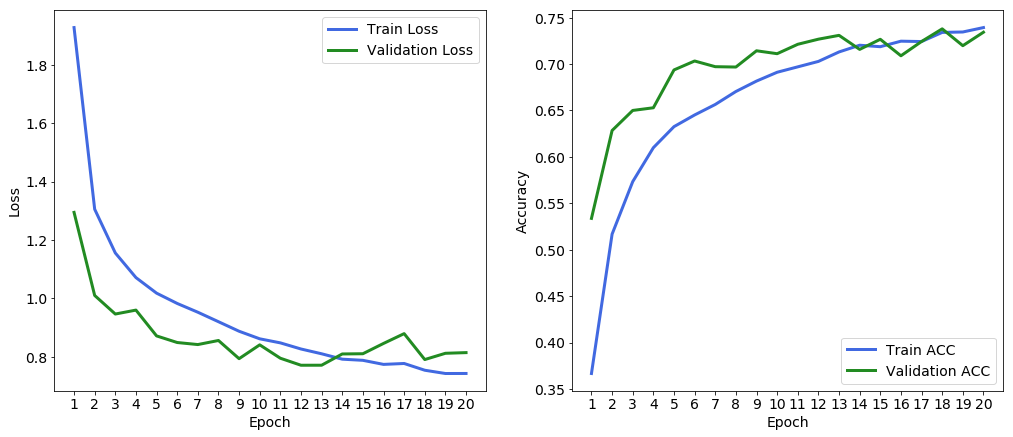

In [43]:
def plotHistory(history):   
    mpl.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))

    # Loss
    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
            label="Train Loss", color="royalblue", lw=3)

    axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
            label="Validation Loss", color="forestgreen", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1))
    axes[0].legend()

    # Accuracy
    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
            label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
            label="Validation ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1))
    axes[1].legend()
    plt.show()
plotHistory(historyA)

## Modelo para o treinamento com os rótulos do grupo `B`
Para o grupo B, o trabalho especificou três redes diferentes, com técnicas de treinamento diferentes, sendo a primeira o treinamento desde a primeira camada, a segunda com *fine tuning* da última camada, e a terceira com *fine tuning* de duas camadas, sendo as últimas duas práticas da prática do *Transfer Learning*.
### O modelo sem *Transfer Learning*
Para o treinamento do primeiro modelo com os rótulos `B`, não farei nenhuma mudança na rede neural, continuando com os mesmos hiperparâmetros e a mesma disposição da rede `A`.  
![imagem_NN](https://raw.githubusercontent.com/ptcar2009/TP_ML_2/master/.images/diagram.png)

Para o treinamento desse, simplesmente usei os dados do grupo `B` no treinamento e validação, ao invés do grupo `A`.

In [67]:
modelB = startModel()

optimizerB = keras.optimizers.Adam(
    lr=0.001)

modelB.compile(
    optimizerB,
    loss="categorical_crossentropy",
    metrics=["accuracy"])

historyB = modelB.fit(
    train_x_b,
    train_y_b,
    batch_size=32,
    epochs=20,
    validation_data=(
        test_x_b,
        test_y_b)
    )


Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 7s 703us/sample - loss: 0.9102 - acc: 0.8585 - val_loss: 0.1898 - val_acc: 0.9250
Epoch 2/20
10000/10000 [==============================] - 6s 630us/sample - loss: 0.2034 - acc: 0.9271 - val_loss: 0.1298 - val_acc: 0.9555
Epoch 3/20
10000/10000 [==============================] - 6s 627us/sample - loss: 0.1743 - acc: 0.9387 - val_loss: 0.1112 - val_acc: 0.9535
Epoch 4/20
10000/10000 [==============================] - 6s 627us/sample - loss: 0.1366 - acc: 0.9536 - val_loss: 0.0974 - val_acc: 0.9660
Epoch 5/20
10000/10000 [==============================] - 6s 627us/sample - loss: 0.1371 - acc: 0.9530 - val_loss: 0.1072 - val_acc: 0.9585
Epoch 6/20
10000/10000 [==============================] - 6s 626us/sample - loss: 0.1212 - acc: 0.9611 - val_loss: 0.0743 - val_acc: 0.9725
Epoch 7/20
10000/10000 [==============================] - 6s 627us/sample - loss: 0.0866 - acc: 0.9695 - val_lo

### O modelo com o *fine tuning* em uma camada
Para a aplicação do processo de *Transfer Learning*, eu criei um modelo com o mesmo formato que o modelo original `A`, e copiei todos os pesos de `A` para `BA1`, sendo `BA1` o modelo com transfer learning. Em todas as camadas menos a última, eu desativei o treinamento dos parâmetros, o que gera um modelo com o formato abaixo.  
![imagem_NN](https://raw.githubusercontent.com/ptcar2009/TP_ML_2/master/.images/modelB.png)

In [68]:
modelBA1 = startModel()
modelBA1.set_weights(modelA.get_weights())

for layer in modelBA1.layers[:-1]:
  layer.trainable = False
modelBA1.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 256)       295168    
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 256)         0  

Para o treinamento dessa camada, a única diferença foi a diminuição do *learning rate*, pois os dados são menos volumosos e isso evita o *overfitting* e a divergência do modelo em um número idêntico de épocas.

In [69]:
optimizerBA1 = keras.optimizers.Adam(
    lr=0.001)

modelBA1.compile(
    optimizerBA1,
    loss="categorical_crossentropy", 
    metrics=["accuracy"])

historyBA1 = modelBA1.fit(
    train_x_b,
    train_y_b,
    batch_size=32,
    epochs=20,
    validation_data=(
        test_x_b,
        test_y_b)
    )

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 4s 409us/sample - loss: 82.5431 - acc: 2.0000e-04 - val_loss: 54.4637 - val_acc: 0.0000e+00
Epoch 2/20
10000/10000 [==============================] - 3s 321us/sample - loss: 29.7636 - acc: 0.1024 - val_loss: 9.8081 - val_acc: 0.2890
Epoch 3/20
10000/10000 [==============================] - 3s 314us/sample - loss: 7.5325 - acc: 0.4402 - val_loss: 1.7997 - val_acc: 0.6940
Epoch 4/20
10000/10000 [==============================] - 3s 313us/sample - loss: 2.9748 - acc: 0.6531 - val_loss: 0.7779 - val_acc: 0.8390
Epoch 5/20
10000/10000 [==============================] - 3s 313us/sample - loss: 1.8464 - acc: 0.7481 - val_loss: 0.5040 - val_acc: 0.8895
Epoch 6/20
10000/10000 [==============================] - 3s 309us/sample - loss: 1.3484 - acc: 0.7922 - val_loss: 0.3893 - val_acc: 0.9140
Epoch 7/20
10000/10000 [==============================] - 3s 307us/sample - loss: 1.1034 - acc: 0.81

### O modelo com *fine tuning* em duas camadas
Com o mesmo processo do modelo com *fine tuning* em somente uma camada, eu criei um modelo novo com os mesmos hiperparâmetros dos anteriores, copiei os pesos do modelo `A` e desativei o treinamento em todas as camadas menos as 3 últimas, visto que a penúltima camada é de *dropout*, e o fine tuning será aplicado nas duas camadas *fully connected*, e a segunda está abaixo da camada de *dropout*, que já não é treinável. Isso gera um modelo com o seguinte formato:  
![imagem_NN](https://raw.githubusercontent.com/ptcar2009/TP_ML_2/master/.images/modelB2.png)

In [70]:
modelBA2 = startModel()
modelBA2.set_weights(modelA.get_weights())

for layer in modelBA2.layers[:-3]:
  layer.trainable = False
modelBA2.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 256)       295168    
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 256)         0  

O treinamento do modelo é idêntico ao treinamento com *fine tuning* em uma camada.

In [71]:
optimizerBA2 = keras.optimizers.Adam(
    lr=0.001)

modelBA2.compile(
    optimizerBA2,
    loss="categorical_crossentropy", 
    metrics=["accuracy"])

historyBA2 = modelBA2.fit(
    train_x_b,
    train_y_b,
    batch_size=32,
    epochs=20,
    validation_data=(
        test_x_b,
        test_y_b)
    )

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 4s 427us/sample - loss: 17.2445 - acc: 0.3284 - val_loss: 0.5824 - val_acc: 0.9335
Epoch 2/20
10000/10000 [==============================] - 4s 352us/sample - loss: 1.7372 - acc: 0.6764 - val_loss: 0.1987 - val_acc: 0.9450
Epoch 3/20
10000/10000 [==============================] - 3s 348us/sample - loss: 1.0425 - acc: 0.7540 - val_loss: 0.1101 - val_acc: 0.9615
Epoch 4/20
10000/10000 [==============================] - 3s 343us/sample - loss: 0.8301 - acc: 0.7852 - val_loss: 0.1046 - val_acc: 0.9630
Epoch 5/20
10000/10000 [==============================] - 3s 337us/sample - loss: 0.6270 - acc: 0.8303 - val_loss: 0.0881 - val_acc: 0.9690
Epoch 6/20
10000/10000 [==============================] - 3s 336us/sample - loss: 0.4805 - acc: 0.8601 - val_loss: 0.0886 - val_acc: 0.9705
Epoch 7/20
10000/10000 [==============================] - 3s 338us/sample - loss: 0.4269 - acc: 0.8750 - val_l

## Análise da performance dos modelos
### Modelo `A`
No modelo `A`, a rede neural foi criada com otimização baseada no treinamento com os dados `A`, portanto sua performance é convergente e regularizada.

In [0]:
# Matriz de Confusao
def confMatrix(modelName, x_test, y_test, model):
  # Predições
  y_proba = model.predict(x_test)
  y_pred = np.argmax(y_proba, axis=1)

  # Labels (desfaz o one-hot encode)
  y_true = np.argmax(y_test, axis=1)

  cm = metrics.confusion_matrix(y_true, y_pred)
  classes = list(range(1, 11))
  fig, ax = plt.subplots(figsize=(7, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title="Matriz de Confusão " + modelName,
         ylabel="Real",
         xlabel="Predito")

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], "d"),
                  ha="center", va="center",
                  color="white" if cm[i, j] > cm.max()/2. else "black")
  fig.tight_layout()
  plt.show()

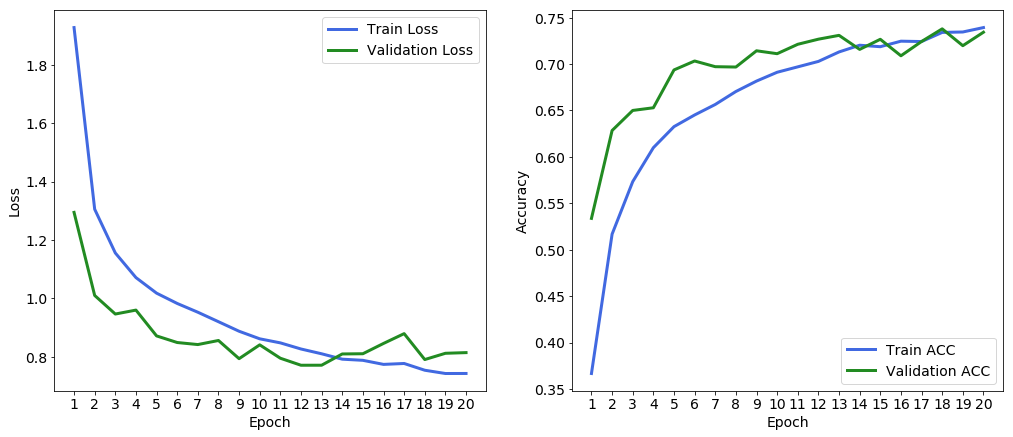

In [72]:
plotHistory(historyA)

Como visto nos gráficos acima, a função de perda e o erro de treino decaem constantemente durante as épocas, e a acurácia de teste permanece próxima à acurácia de treino, o que descreve um modelo regularizado.

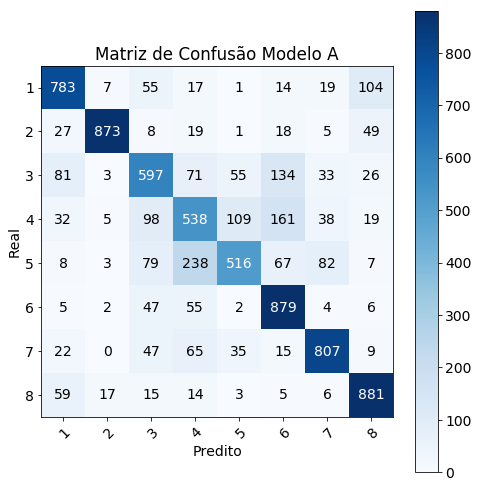

In [73]:
confMatrix("Modelo A", test_x_a, test_y_a, modelA)

O modelo apresenta uma matriz de confusão diagonalizada, o que remete à alta acurácia do modelo, sendo o número de falsos positivos e negativos baixo.

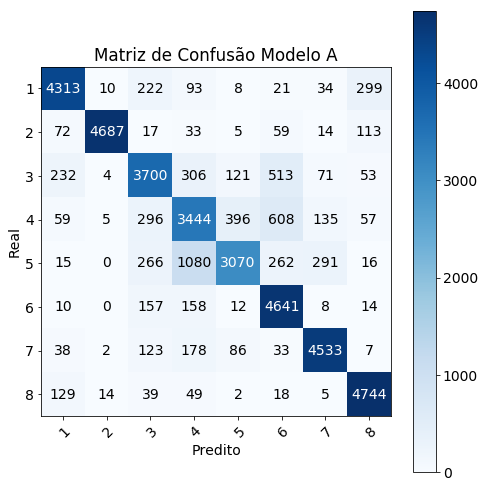

In [50]:
confMatrix("Modelo A", train_x_a, train_y_a, modelA)

A matriz de confusão de treino e de teste do modelo `A` são similares, outro sintoma de um modelo regularizado.

### Modelo `B` sem *Transfer Learning*

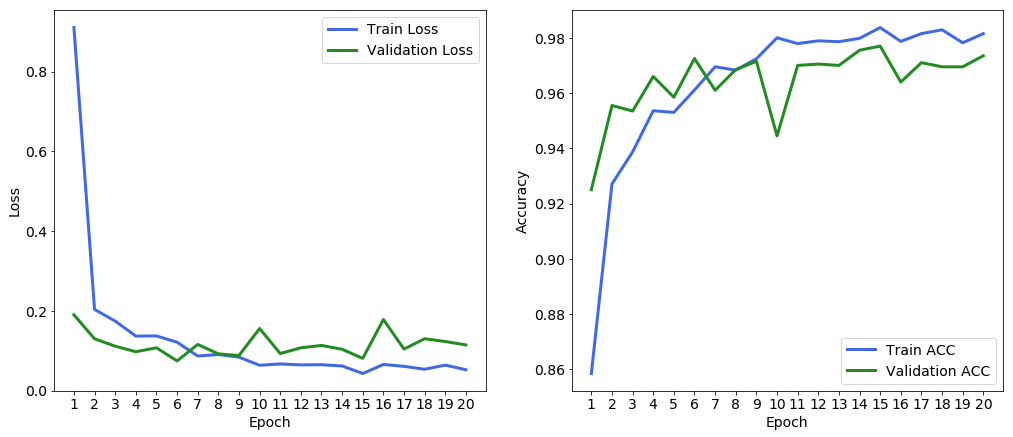

In [74]:
plotHistory(historyB)

Para o modelo `B`, a perda e a acurácia de treino melhoram durante as épocas assim como no `A`, porém o modelo apresenta sintomas de *overfitting*, visto que a acurácia de validação se estabiliza em um valor menor do que a acurácia de treino.  

Isso pode ser explicado pelo número menor de amostras de treino no banco de amostras `B`, que, visto que a complexidade do modelo continua  a mesma, não é o suficiente para atingir a capacidade do modelo, causando um *overfitting*. 

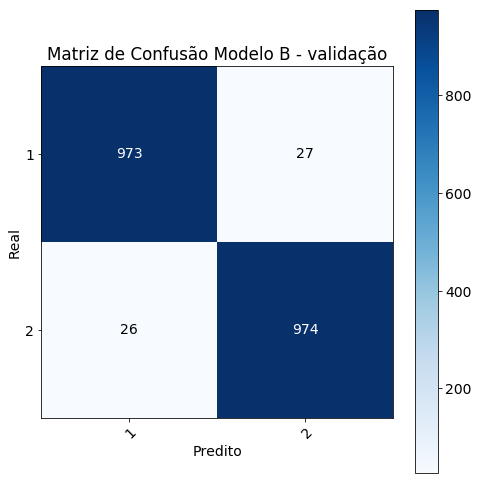

In [75]:
confMatrix("Modelo B - validação", test_x_b, test_y_b, modelB)


Apesar de o modelo apresentar uma matriz de confusão diagonalizada, o *overfitting* fica claro  quando comparamos a matriz de confusão de validação com a matriz de confusão de treino, que é extremamente mais precisa. 

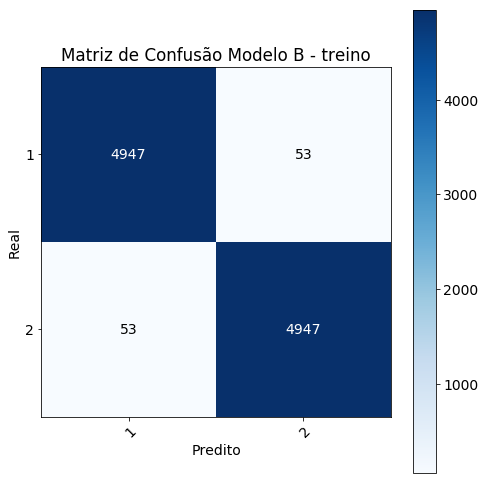

In [76]:
confMatrix("Modelo B - treino", train_x_b, train_y_b, modelB)

### Modelo B com *transfer learning*
#### *Fine tuning* em uma camada

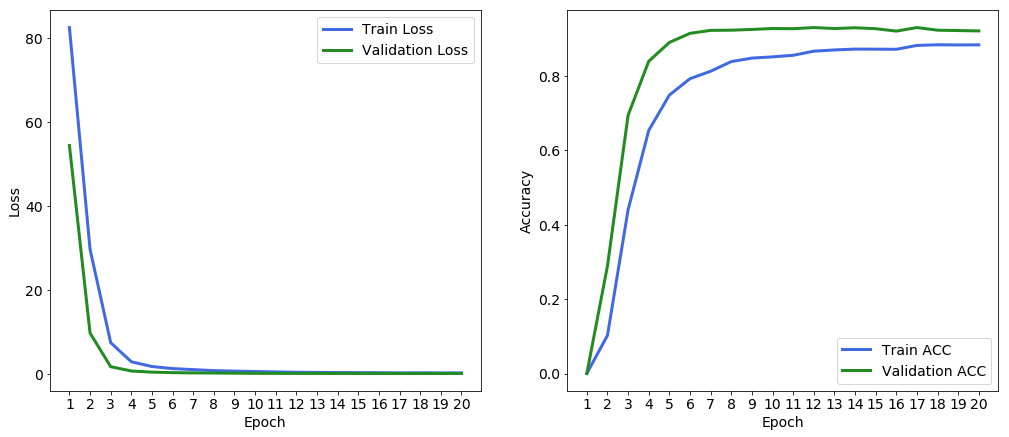

In [77]:
plotHistory(historyBA1)

A acurácia com o *fine tuning* em uma camada foi menor do que a acurácia com o treinamento completo do modelo, porém o modelo não apresenta nenhum traço de *overfitting* e o tempo de treinamento foi muito menor. 

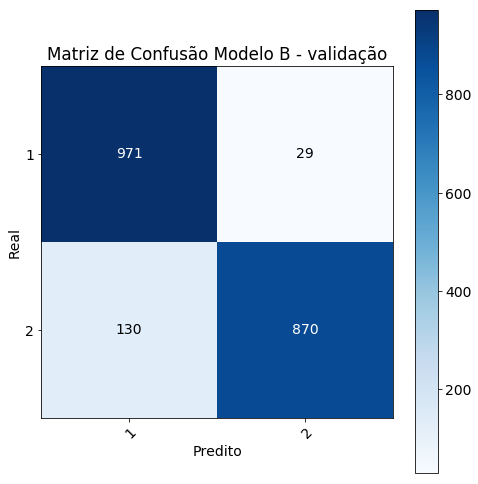

In [78]:
confMatrix("Modelo B - validação", test_x_b, test_y_b, modelBA1)

As matrizes de confusão demonstram a diminuição significativa do *overfitting*, visto que a matriz de treino e de teste apresentam condições similares de diagonalização.

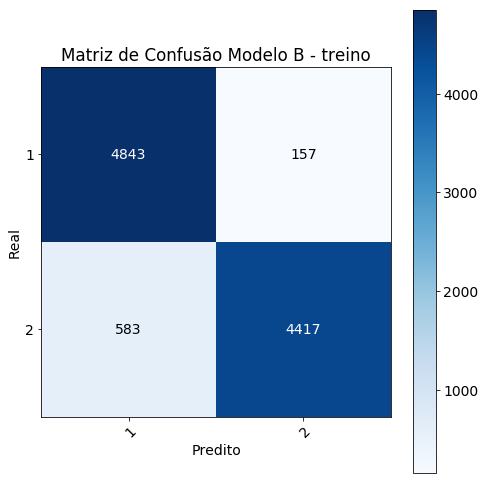

In [79]:
confMatrix("Modelo B - treino", train_x_b, train_y_b, modelBA1)

#### Modelo com duas camadas de *fine tuning*

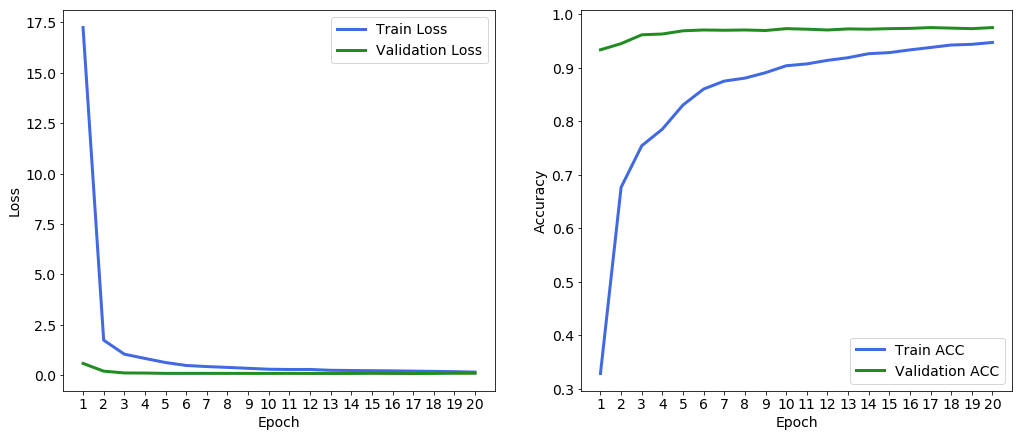

In [81]:
plotHistory(historyBA2)

Ambas as acurácias de treino e validação com duas camadas de *fine tuning* possuem valores altos, e o modelo não apresenta sintomas de *overfitting*, visto que sua acurácia e perda de validação se demonstram constantes e sempre melhores do que a de treino. 

O modelo aparenta estar regularizado, e seu tempo de treinamento foi reduzido à metade quando comparado com o modelo com treino completo.

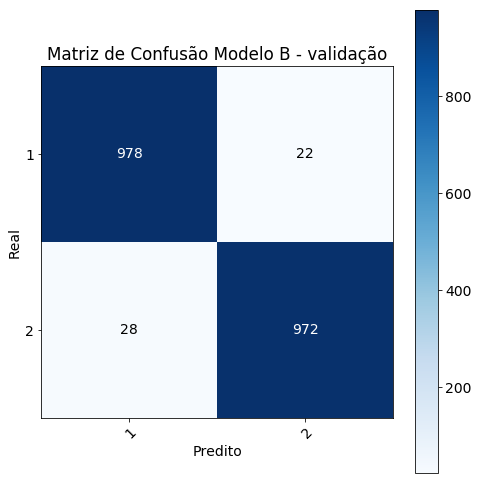

In [80]:
confMatrix("Modelo B - validação", test_x_b, test_y_b, modelBA2)

As matrizes de confusão apresentam perfis similares e diagonalizados, também sintomas de um modelo preciso e regularizado.

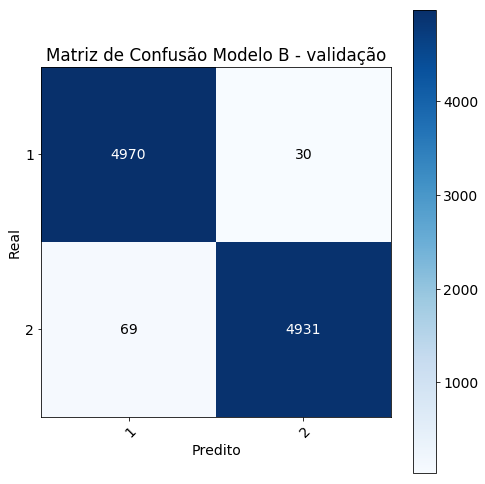

In [82]:
confMatrix("Modelo B - validação", train_x_b, train_y_b, modelBA2)

### Conclusão da análise
Todos os métodos de treinamento são válidos, porém o método de treinamento completo, aplicado no primeiro modelo, é computacionalmente custoso, e pode causar *overfitting* devido a um número pequeno de dados de treino.

O segundo método, com *fine tuning* em uma camada, apresenta resutados inferiores aos outros dois métodos, porém é o com menos custo computacional de treino, e ele converge mais rapidamente também, devido ao menor número de parâmetros treináveis.

O terceiro método se mostrou o mais eficaz, com boa acurácia em geral e sem sinais de *overfitting*. Seu treinamento foi rápido e pouco custoso comparado com o treinamento completo, e a falta de dados não interferiu com relevância no resultado da validação dos dados.

## Erros de cada modelo

In [0]:
def errors(x_test, y_test, model):
  # Predições
  y_proba = model.predict(x_test)
  y_pred = np.argmax(y_proba, axis=1)

  # Labels (desfaz o one-hot encode)
  y_true = np.argmax(y_test, axis=1)

  missed = y_pred != y_true

  x_missed = x_test[missed]
  y_missed = y_pred[missed] 
  y_true_missed = y_true[missed] 

  n_rows = 2
  n_cols = 3
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

  for i in range(n_rows):
      for j in range(n_cols):
          img_i = np.random.randint(0, x_missed.shape[0])
          axes[i][j].imshow(x_missed[img_i, :, :, 0], cmap="gray")
          axes[i][j].set_title("Predito {} (certo era {})".format(classes[y_missed[img_i]], classes[y_true_missed[img_i]]))
          axes[i][j].axis("off")
  plt.show()

### Modelo A

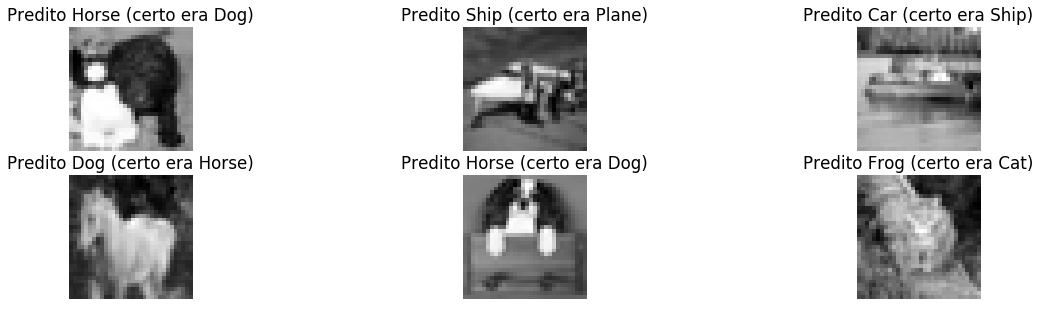

In [93]:
errors(test_x_a, test_y_a, modelA)

Os erros se mostram entre categorias similares, animais com animais e veículos com veículos.
### Modelos B
#### B Sem *transfer*

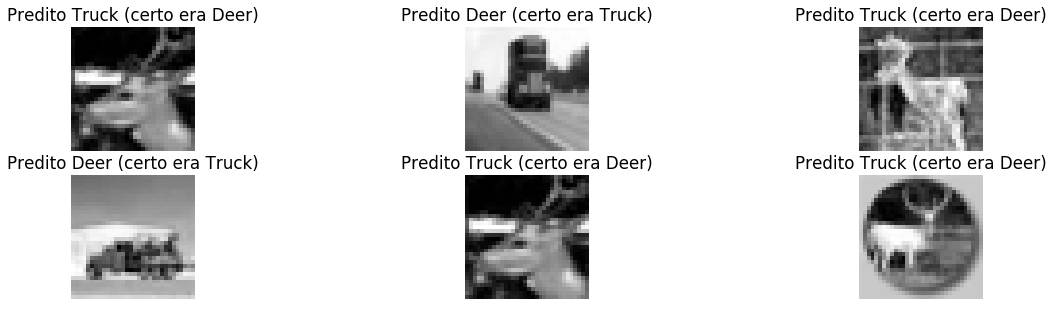

In [94]:
errors(test_x_b, test_y_b, modelB)

#### Uma camada de *fine tuning*

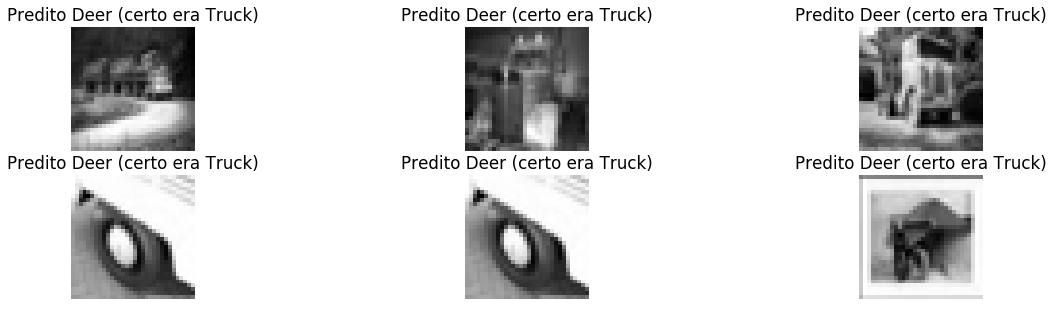

In [95]:
errors(test_x_b, test_y_b, modelBA1)

#### Duas camadas de *fine tuning*

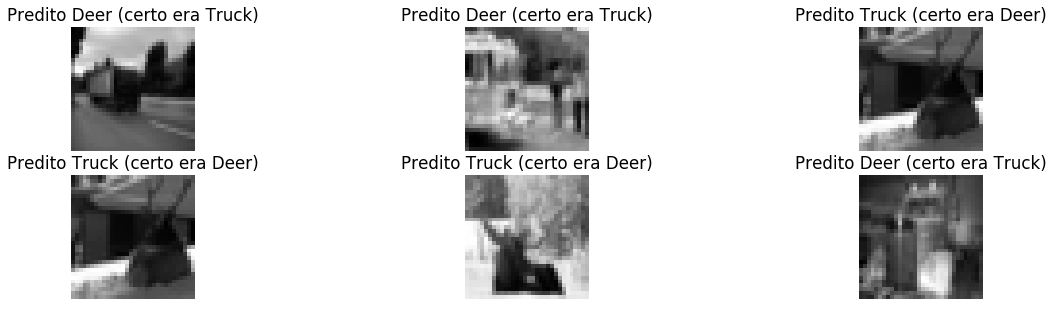

In [96]:
errors(test_x_b, test_y_b, modelBA2)